In [2]:
!pip install -r requirements.txt
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

In [3]:
# Load the data
df = pd.read_csv('data/US_Accidents_March23_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249353 entries, 0 to 249352
Data columns (total 44 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               249353 non-null  int64  
 1   Start_Lat              249353 non-null  float64
 2   Start_Lng              249353 non-null  float64
 3   Street                 249353 non-null  object 
 4   City                   249353 non-null  object 
 5   County                 249353 non-null  object 
 6   State                  249353 non-null  object 
 7   Zipcode                249353 non-null  object 
 8   Timezone               249353 non-null  object 
 9   Airport_Code           249353 non-null  object 
 10  Temperature(F)         249353 non-null  float64
 11  Humidity(%)            249353 non-null  float64
 12  Pressure(in)           249353 non-null  float64
 13  Visibility(mi)         249353 non-null  float64
 14  Wind_Direction         249353 non-nu

In [4]:
class DecisionTree:
    def __init__(
        self, max_depth=None, feature_sampling_factor=1.0, threshold_sampling_factor=1.0
    ):
        self.max_depth = max_depth
        self.feature_sampling_factor = feature_sampling_factor
        self.threshold_sampling_factor = threshold_sampling_factor

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.num_classes_ = len(self.classes_)
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self.classes_[self._traverse_tree(x, self.tree)] for x in X])

    def predict_proba(self, X):
        return np.array([self._traverse_tree_proba(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth=0):
        num_labels = len(np.unique(y))

        # Base case: Leaf node (return class distribution as probabilities)
        if depth == self.max_depth or num_labels == 1 or len(y) == 0:
            leaf_distribution = np.zeros(self.num_classes_)
            if len(y) > 0:
                unique_classes, counts = np.unique(y, return_counts=True)
                leaf_distribution[np.searchsorted(self.classes_, unique_classes)] = (
                    counts / len(y)
                )
            return {"leaf": True, "class_distribution": leaf_distribution}

        best_feature, best_threshold = self._find_best_split(X, y)

        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {
            "feature": best_feature,
            "threshold": best_threshold,
            "left": left_tree,
            "right": right_tree,
            "leaf": False,
        }

    def _find_best_split(self, X, y):
        best_gain = 0
        best_feature = None
        best_threshold = None

        num_samples, num_features = X.shape
        sampled_features = np.random.choice(
            num_features,
            int(self.feature_sampling_factor * num_features),
            replace=False,
        )

        for feature in sampled_features:
            thresholds = np.unique(X[:, feature])
            sampled_thresholds = np.random.choice(
                thresholds,
                int(self.threshold_sampling_factor * len(thresholds)),
                replace=False,
            )

            for threshold in sampled_thresholds:
                gain = self._calculate_gain(X, y, feature, threshold)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gain(self, X, y, feature, threshold):
        parent_entropy = self._calculate_entropy(y)

        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold

        left_entropy = self._calculate_entropy(y[left_indices])
        right_entropy = self._calculate_entropy(y[right_indices])

        num_left = len(y[left_indices])
        num_right = len(y[right_indices])
        total_samples = num_left + num_right

        gain = (
            parent_entropy
            - ((num_left / total_samples) * left_entropy)
            - ((num_right / total_samples) * right_entropy)
        )

        return gain

    def _calculate_entropy(self, y):
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))

        return entropy

    def _traverse_tree(self, x, tree):
        if tree.get("leaf"):
            return np.argmax(tree["class_distribution"])
        else:
            feature = tree["feature"]
            threshold = tree["threshold"]

            if x[feature] <= threshold:
                return self._traverse_tree(x, tree["left"])
            else:
                return self._traverse_tree(x, tree["right"])

    def _traverse_tree_proba(self, x, tree):
        if tree.get("leaf"):
            return tree["class_distribution"]
        else:
            feature = tree["feature"]
            threshold = tree["threshold"]

            if x[feature] <= threshold:
                return self._traverse_tree_proba(x, tree["left"])
            else:
                return self._traverse_tree_proba(x, tree["right"])

In [5]:
# Load the models
rf_model = load('models/random_forest_model.pkl')
dt_model = load('models/decision_tree_model.pkl')
nb_model = load('models/naive_bayes_model.pkl')

In [7]:
df = df.drop(['Zipcode', 'Airport_Code','Street', 'Year', 'Start_Lat', 'Start_Lng', "Timezone"], axis=1)
df_dummy = pd.get_dummies(df, drop_first=True)

target='Severity'

y = df_dummy[target]
X = df_dummy.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

KeyError: "['Zipcode', 'Airport_Code', 'Street'] not found in axis"

In [10]:
# Make predictions
from sklearn.metrics import accuracy_score
# Random Forest
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

# Decision Tree
y_pred_dt = dt_model.predict(X_test.values)
y_proba_dt = dt_model.predict_proba(X_test.values)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")

# Naive Bayes
y_pred_nb = nb_model.predict(X_test)
y_proba_nb = nb_model.predict_proba(X_test)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_accuracy:.2f}")

Decision Tree Accuracy: 0.25


## Classification Report

In [8]:
print("Classification Report for Random Forest Model")
print(classification_report(y_test, y_pred_rf))


Classification Report for Random Forest Model
              precision    recall  f1-score   support

           1       0.81      0.91      0.86      6491
           2       0.65      0.52      0.58      6658
           3       0.62      0.67      0.65      6657
           4       0.65      0.64      0.65      6374

    accuracy                           0.69     26180
   macro avg       0.68      0.69      0.68     26180
weighted avg       0.68      0.69      0.68     26180



In [9]:
print("Classification Report for Decision Tree Model")
print(classification_report(y_test, y_pred_dt))

Classification Report for Decision Tree Model
              precision    recall  f1-score   support

           1       0.55      0.98      0.70      6491
           2       0.51      0.36      0.42      6658
           3       0.53      0.59      0.56      6657
           4       0.53      0.20      0.30      6374

    accuracy                           0.53     26180
   macro avg       0.53      0.53      0.49     26180
weighted avg       0.53      0.53      0.49     26180



In [ ]:
print("Classification Report for Naive Bayes Model")
print(classification_report(y_test, y_pred_nb))

## Confusion Matrix

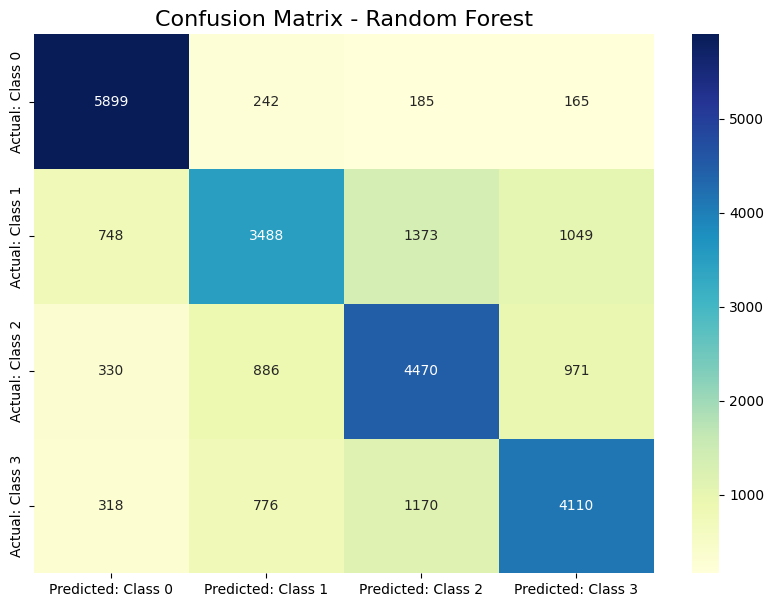

In [10]:
# Random Forest
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)

# Adjusting the labels for a 4-class model
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted: Class 0', 'Predicted: Class 1', 'Predicted: Class 2', 'Predicted: Class 3'],
                           index=['Actual: Class 0', 'Actual: Class 1', 'Actual: Class 2', 'Actual: Class 3'])

plt.figure(figsize = (10, 7))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix - Random Forest", fontsize=16)  # Adding title
plt.show()

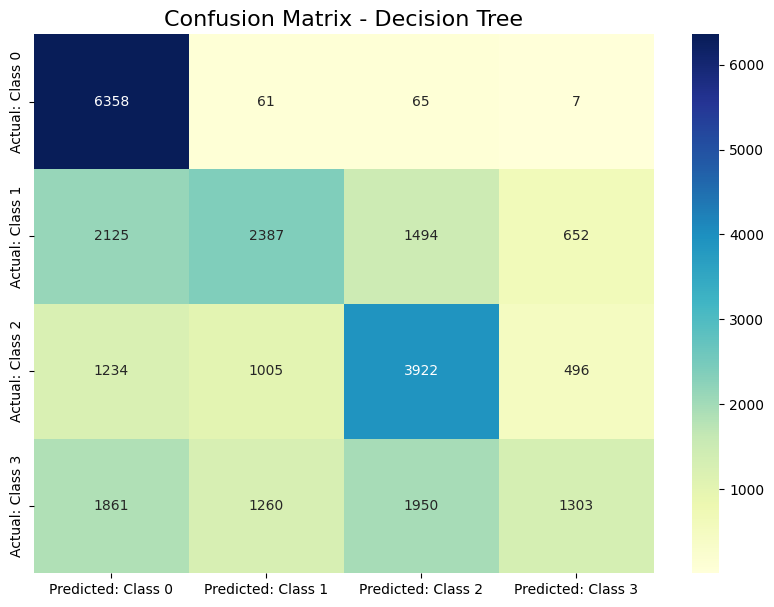

In [11]:
# Decision Tree
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_dt)

# Adjusting the labels for a 4-class model
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted: Class 0', 'Predicted: Class 1', 'Predicted: Class 2', 'Predicted: Class 3'],
                           index=['Actual: Class 0', 'Actual: Class 1', 'Actual: Class 2', 'Actual: Class 3'])

plt.figure(figsize = (10, 7))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix - Decision Tree", fontsize=16)  # Adding title
plt.show()

In [ ]:
# Naive Bayes
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_nb)

# Adjusting the labels for a 4-class model
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted: Class 0', 'Predicted: Class 1', 'Predicted: Class 2', 'Predicted: Class 3'],
                           index=['Actual: Class 0', 'Actual: Class 1', 'Actual: Class 2', 'Actual: Class 3'])

plt.figure(figsize = (10, 7))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix - Decision Tree", fontsize=16)  # Adding title
plt.show()

## ROC Curve

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


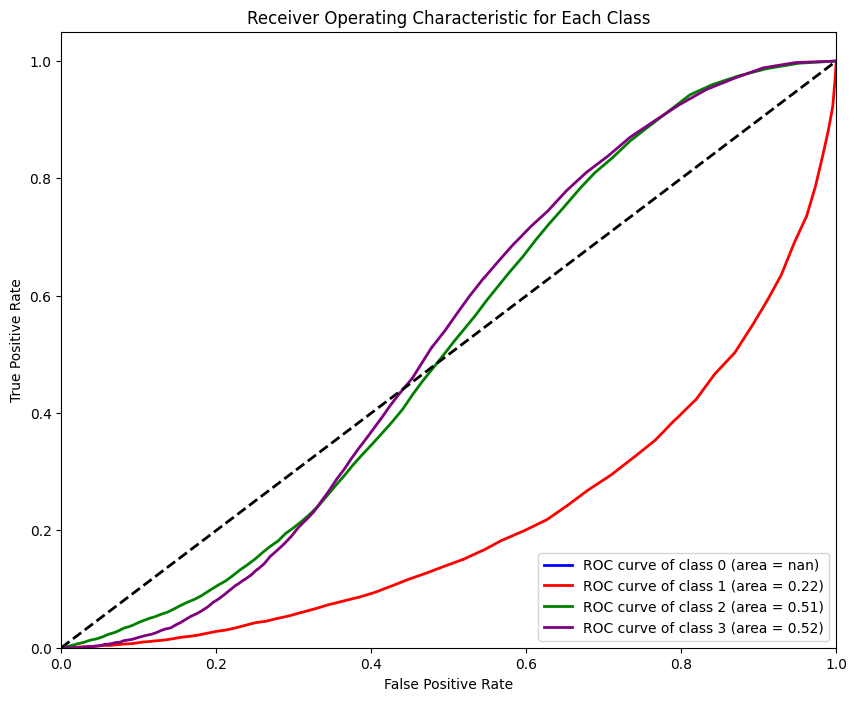

In [28]:
# Random Forest
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# Calculate ROC curve and ROC area for each class
n_classes = y_proba_rf.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


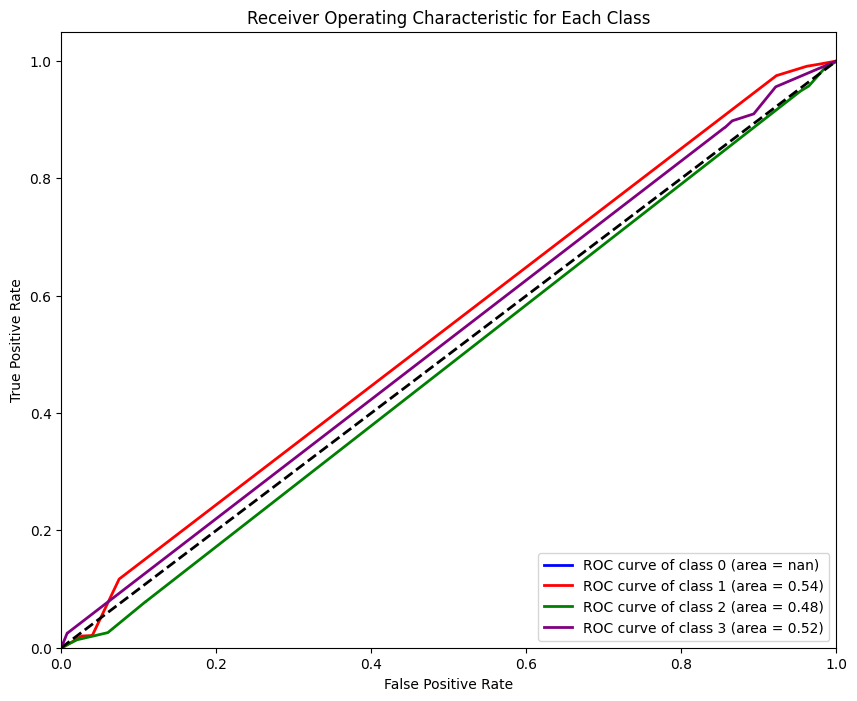

In [11]:
# Decision Tree
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# Calculate ROC curve and ROC area for each class
n_classes = y_proba_dt.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_dt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Naive Bayes
# replace y_proba_rf with y_proba_nb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

n_classes = y_proba_nb.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_nb[:, i]) # replace y_proba_rf with y_proba_nb
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()

## Cross Validation

In [38]:
# Random Forest
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X, y, cv=5)  # By default, the score computed at each CV iteration is the score method of the estimator (accuracy for classifiers).

# Print the results
print("Accuracy scores for 5-fold cross-validation:")
print(scores)
print("\nAverage cross-validation score: {:.2f}".format(np.mean(scores)))




Accuracy scores for 5-fold cross-validation:
[0.68235294 0.68846448 0.69009511 0.68138584 0.68723022]

Average cross-validation score: 0.69


In [ ]:
# Decision Tree
import numpy as np
from sklearn.model_selection import KFold

# Assuming 'X' and 'y' are pandas DataFrame and Series respectively
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in kf.split(X):
    # Correct indexing for pandas
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Assuming 'DecisionTree' is your model class
    model = DecisionTree(max_depth=5)  # Adjust max_depth as needed

    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate accuracy or other metrics
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

# Display results
print("Cross-Validated Accuracies:", accuracies)
print("Average Cross-Validated Accuracy:", np.mean(accuracies))

In [ ]:
# Naive Bayes
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nb_model, X, y, cv=5)  # By default, the score computed at each CV iteration is the score method of the estimator (accuracy for classifiers).

# Print the results
print("Accuracy scores for 5-fold cross-validation:")
print(scores)
print("\nAverage cross-validation score: {:.2f}".format(np.mean(scores)))